### Loading the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [2]:
%matplotlib inline
sns.set()

In [3]:
df = pd.read_csv('AmesHousing.tsv', sep='\t')
df.shape

(2930, 82)

### First look at data

In [4]:
# checking the columns types and values
pd.options.display.max_rows = 82

pd.concat([pd.Series(df.dtypes, name='type'),
           pd.Series(df.nunique(), name='n unique'),
           pd.Series(df.isnull().sum(), name='n null'),
           df.head(3).T,
           df.tail(3).T], axis=1)

,type,n unique,n null,0,1,2,2927,2928,2929
Order,int64,2930,0,1,2,3,2928,2929,2930
PID,int64,2930,0,526301100,526350040,526351010,923400125,924100070,924151050
MS SubClass,int64,16,0,20,20,20,85,20,60
MS Zoning,object,7,0,RL,RH,RL,RL,RL,RL
Lot Frontage,float64,128,490,141,80,81,62,77,74
Lot Area,int64,1960,0,31770,11622,14267,10441,10010,9627
Street,object,2,0,Pave,Pave,Pave,Pave,Pave,Pave
Alley,object,2,2732,NaN,NaN,NaN,NaN,NaN,NaN
Lot Shape,object,4,0,IR1,Reg,IR1,Reg,Reg,Reg
Land Contour,object,4,0,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl


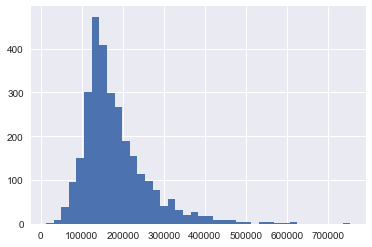

In [5]:
df['SalePrice'].hist(bins=40)
plt.show()

### Helper functions

In [6]:
def transform_features(df):
    return df

def select_features(df):
    return df[["Gr Liv Area", "SalePrice"]]

def train_and_test(df):
    #middle_row = int(df.shape[0] / 2) # won't use for now
    train = df.iloc[:1460].copy()
    test = df.iloc[1460:].copy()
    
    num_train = train.select_dtypes(include=['floating', 'integer'])
    num_test = test.select_dtypes(include=['floating', 'integer'])
    
    lr = LinearRegression()
    
    features = num_train.columns.drop(['SalePrice'])
    target = 'SalePrice'
    
    lr.fit(num_train[features], num_train[target])    
    train_pred = lr.predict(train[features])
    test_pred = lr.predict(test[features])
    
    test_mse = mean_squared_error(test[target], test_pred)
    test_rmse = np.sqrt(test_mse)
    
    return test_rmse

In [7]:
# benchmark

transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

57088.25161263909

### Feature engineering

#### 1. Text features - handling missing values

In [8]:
text_cols_nulls = df.select_dtypes(include=['object']).isnull().sum()
text_cols_nulls[text_cols_nulls > 0]

Alley             2732
Mas Vnr Type        23
Bsmt Qual           80
Bsmt Cond           80
Bsmt Exposure       83
BsmtFin Type 1      80
BsmtFin Type 2      81
Electrical           1
Fireplace Qu      1422
Garage Type        157
Garage Finish      159
Garage Qual        159
Garage Cond        159
Pool QC           2917
Fence             2358
Misc Feature      2824
dtype: int64

We'll drop all columns with >1 missing value (so except 'Electrical').

In [9]:
text_cols_to_drop = text_cols_nulls[text_cols_nulls > 1]
df = df.drop(text_cols_to_drop.index, axis=1)
df.shape

(2930, 67)

_Electrical_ seems to be important (according to [data description](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt)). So we better impute it with most popular value.

In [10]:
df['Electrical'].value_counts()

SBrkr    2682
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [11]:
impute_value = df['Electrical'].mode().values[0]
impute_dict = {'Electrical': impute_value}

df = df.fillna(value=impute_dict)
df['Electrical'].value_counts()

SBrkr    2683
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [12]:
# checking that no more missing values for text columns.
df.select_dtypes(include=['object']).isnull().sum()

MS Zoning         0
Street            0
Lot Shape         0
Land Contour      0
Utilities         0
Lot Config        0
Land Slope        0
Neighborhood      0
Condition 1       0
Condition 2       0
Bldg Type         0
House Style       0
Roof Style        0
Roof Matl         0
Exterior 1st      0
Exterior 2nd      0
Exter Qual        0
Exter Cond        0
Foundation        0
Heating           0
Heating QC        0
Central Air       0
Electrical        0
Kitchen Qual      0
Functional        0
Paved Drive       0
Sale Type         0
Sale Condition    0
dtype: int64

#### 2. Numerical columns - handling missing values.

In [13]:
num_cols_nulls = df.select_dtypes(include=['floating', 'integer']).isnull().sum()
num_cols_nulls[num_cols_nulls > 0]

Lot Frontage      490
Mas Vnr Area       23
BsmtFin SF 1        1
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
Bsmt Full Bath      2
Bsmt Half Bath      2
Garage Yr Blt     159
Garage Cars         1
Garage Area         1
dtype: int64

We'll drop columns with >2 missing values. And imputes the rest with modes.

In [14]:
num_cols_to_drop = num_cols_nulls[num_cols_nulls > 2]
num_cols_to_drop

Lot Frontage     490
Mas Vnr Area      23
Garage Yr Blt    159
dtype: int64

In [15]:
df = df.drop(num_cols_to_drop.index, axis=1)
df.shape

(2930, 64)

In [16]:
num_cols_to_impute = num_cols_nulls[(num_cols_nulls > 0) & (num_cols_nulls <= 2)]
num_cols_to_impute

BsmtFin SF 1      1
BsmtFin SF 2      1
Bsmt Unf SF       1
Total Bsmt SF     1
Bsmt Full Bath    2
Bsmt Half Bath    2
Garage Cars       1
Garage Area       1
dtype: int64

In [17]:
num_impute_values = df[num_cols_to_impute.index].mode().iloc[0] # iloc[0] turns dataframe of 1 row into Series object
num_impute_values

BsmtFin SF 1      0.0
BsmtFin SF 2      0.0
Bsmt Unf SF       0.0
Total Bsmt SF     0.0
Bsmt Full Bath    0.0
Bsmt Half Bath    0.0
Garage Cars       2.0
Garage Area       0.0
Name: 0, dtype: float64

In [18]:
df = df.fillna(value=num_impute_values)

In [19]:
# checking that no more missing values

df.select_dtypes(include=['floating', 'integer']).isnull().sum()

Order              0
PID                0
MS SubClass        0
Lot Area           0
Overall Qual       0
Overall Cond       0
Year Built         0
Year Remod/Add     0
BsmtFin SF 1       0
BsmtFin SF 2       0
Bsmt Unf SF        0
Total Bsmt SF      0
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
Gr Liv Area        0
Bsmt Full Bath     0
Bsmt Half Bath     0
Full Bath          0
Half Bath          0
Bedroom AbvGr      0
Kitchen AbvGr      0
TotRms AbvGrd      0
Fireplaces         0
Garage Cars        0
Garage Area        0
Wood Deck SF       0
Open Porch SF      0
Enclosed Porch     0
3Ssn Porch         0
Screen Porch       0
Pool Area          0
Misc Val           0
Mo Sold            0
Yr Sold            0
SalePrice          0
dtype: int64

#### 3. Dropping useless columns and columns with data leakage.

In [20]:
# useless
df = df.drop(['Order', 'PID'], axis=1)

# data leakage
df = df.drop(['Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition'], axis=1)

#### 4. Transforming text columns to dummies.

In [21]:
df = pd.get_dummies(df)

In [22]:
# final check
pd.options.display.max_rows = 300

pd.concat([pd.Series(df.dtypes, name='type'),
           pd.Series(df.nunique(), name='n unique'),
           pd.Series(df.isnull().sum(), name='n null'),
           df.head(3).T,
           df.tail(3).T], axis=1)

,type,n unique,n null,0,1,2,2927,2928,2929
MS SubClass,int64,16,0,20.0,20.0,20.0,85.0,20.0,60.0
Lot Area,int64,1960,0,31770.0,11622.0,14267.0,10441.0,10010.0,9627.0
Overall Qual,int64,10,0,6.0,5.0,6.0,5.0,5.0,7.0
Overall Cond,int64,9,0,5.0,6.0,6.0,5.0,5.0,5.0
Year Built,int64,118,0,1960.0,1961.0,1958.0,1992.0,1974.0,1993.0
Year Remod/Add,int64,61,0,1960.0,1961.0,1958.0,1992.0,1975.0,1994.0
BsmtFin SF 1,float64,995,0,639.0,468.0,923.0,337.0,1071.0,758.0
BsmtFin SF 2,float64,274,0,0.0,144.0,0.0,0.0,123.0,0.0
Bsmt Unf SF,float64,1137,0,441.0,270.0,406.0,575.0,195.0,238.0
Total Bsmt SF,float64,1058,0,1080.0,882.0,1329.0,912.0,1389.0,996.0


### Helper functions - update 1

In [23]:
def transform_features(df):
    # handling text columns 
    text_cols_nulls = df.select_dtypes(include=['object']).isnull().sum()
    text_cols_to_drop = text_cols_nulls[text_cols_nulls > 1]
    df = df.drop(text_cols_to_drop.index, axis=1)

    impute_value = df['Electrical'].mode().values[0]
    impute_dict = {'Electrical': impute_value}

    df = df.fillna(value=impute_dict)
    
    # handling num columns 
    num_cols_nulls = df.select_dtypes(include=['floating', 'integer']).isnull().sum()
    num_cols_to_drop = num_cols_nulls[num_cols_nulls > 2]
    df = df.drop(num_cols_to_drop.index, axis=1)

    num_cols_to_impute = num_cols_nulls[(num_cols_nulls > 0) & (num_cols_nulls <= 2)]
    num_impute_values = df[num_cols_to_impute.index].mode().iloc[0] 
    df = df.fillna(value=num_impute_values)
    
    # dropping not needed
    df = df.drop(['Order', 'PID'], axis=1)
    df = df.drop(['Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition'], axis=1)
    
    # making dummies
    df = pd.get_dummies(df)
    return df

### Selecting features

In [24]:
# we'll import data again and use freshly updated transform function

df = pd.read_csv('AmesHousing.tsv', sep='\t')
df = transform_features(df)

In [25]:
# checking corr with target
abs_corrs = df.corr()['SalePrice'].abs().sort_values(ascending=False)
abs_corrs

SalePrice               1.000000
Overall Qual            0.799262
Gr Liv Area             0.706780
Garage Cars             0.647812
Garage Area             0.640138
Total Bsmt SF           0.632529
1st Flr SF              0.621676
Exter Qual_TA           0.590897
Year Built              0.558426
Full Bath               0.545604
Kitchen Qual_Ex         0.537561
Year Remod/Add          0.532974
Kitchen Qual_TA         0.526721
Foundation_PConc        0.520966
TotRms AbvGrd           0.495474
Exter Qual_Ex           0.480477
Fireplaces              0.474558
Heating QC_Ex           0.454553
Exter Qual_Gd           0.446489
Neighborhood_NridgHt    0.433299
BsmtFin SF 1            0.433147
Foundation_CBlock       0.349642
Heating QC_TA           0.338520
Exterior 1st_VinylSd    0.334416
Exterior 2nd_VinylSd    0.331146
Wood Deck SF            0.327143
Open Porch SF           0.312951
Kitchen Qual_Gd         0.304463
Lot Shape_Reg           0.300461
Neighborhood_NoRidge    0.295005
MS Zoning_

In [26]:
# Let's use a threshold of 0.3
corr_features = abs_corrs[abs_corrs > 0.3]
corr_features

SalePrice               1.000000
Overall Qual            0.799262
Gr Liv Area             0.706780
Garage Cars             0.647812
Garage Area             0.640138
Total Bsmt SF           0.632529
1st Flr SF              0.621676
Exter Qual_TA           0.590897
Year Built              0.558426
Full Bath               0.545604
Kitchen Qual_Ex         0.537561
Year Remod/Add          0.532974
Kitchen Qual_TA         0.526721
Foundation_PConc        0.520966
TotRms AbvGrd           0.495474
Exter Qual_Ex           0.480477
Fireplaces              0.474558
Heating QC_Ex           0.454553
Exter Qual_Gd           0.446489
Neighborhood_NridgHt    0.433299
BsmtFin SF 1            0.433147
Foundation_CBlock       0.349642
Heating QC_TA           0.338520
Exterior 1st_VinylSd    0.334416
Exterior 2nd_VinylSd    0.331146
Wood Deck SF            0.327143
Open Porch SF           0.312951
Kitchen Qual_Gd         0.304463
Lot Shape_Reg           0.300461
Name: SalePrice, dtype: float64

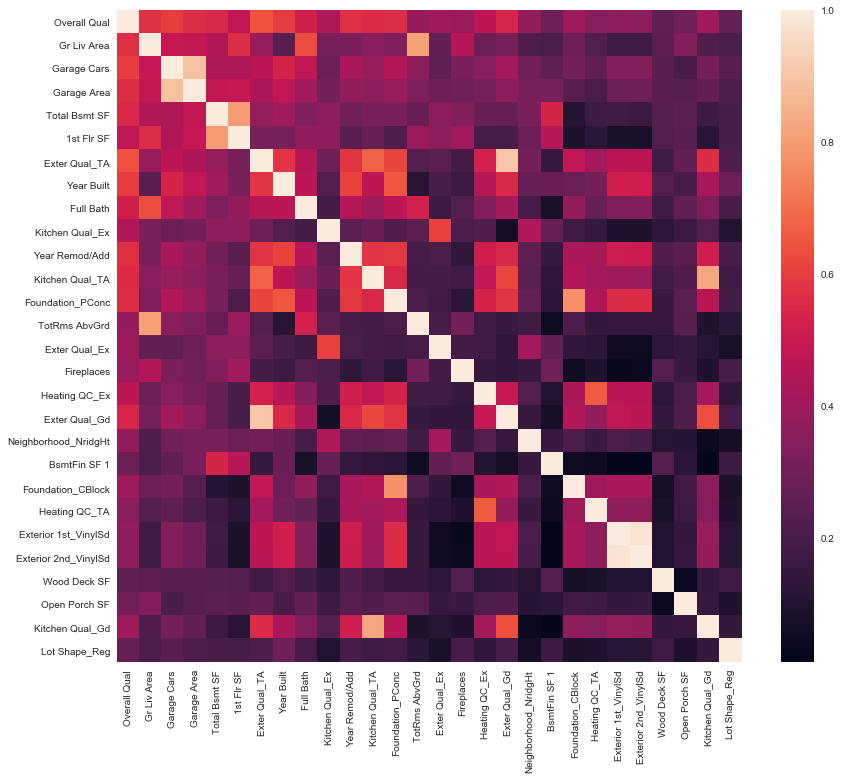

In [27]:
# checking for collinearity

plt.figure(figsize=(14,12))
sns.heatmap(df[corr_features.index.drop('SalePrice')].corr().abs())
plt.show()

### Helper functions - update 2

In [28]:
def select_features(df, threshold=0.3):
    abs_corrs = df.corr()['SalePrice'].abs().sort_values(ascending=False)
    corr_features = abs_corrs[abs_corrs > threshold]
    df = df[corr_features.index]    
    return df

In [29]:
# benchmark 2

df = pd.read_csv('AmesHousing.tsv', sep='\t')
transform_df = transform_features(df)
filtered_df = select_features(transform_df, 0.1)
rmse = train_and_test(filtered_df)

rmse

35512.3568322511

### Helper functions - update 3

In [30]:
def train_and_test(df, k=0):
    
    features = df.columns.drop('SalePrice')
    target = 'SalePrice'    
    lr = LinearRegression()
        
    if k == 0: # holdout validation on 50% test data
        middle_row = int(df.shape[0] / 2) 
        train = df.iloc[:middle_row].copy()
        test = df.iloc[middle_row:].copy()

        lr.fit(train[features], train["SalePrice"])
        test_pred = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], test_pred)
        rmse = np.sqrt(mse)
        
        return rmse
    
    if k == 1: # simple cross-validation
        middle_row = int(df.shape[0] / 2) 
        shuffled_df = df.sample(frac=1)
        fold_one = shuffled_df.iloc[:middle_row].copy()
        fold_two = shuffled_df.iloc[middle_row:].copy()
        
        lr.fit(fold_one[features], fold_one["SalePrice"])
        pred_one = lr.predict(fold_two[features])        
        
        mse_one = mean_squared_error(fold_two["SalePrice"], pred_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(fold_two[features], fold_two["SalePrice"])
        pred_two = lr.predict(fold_one[features])        
       
        mse_two = mean_squared_error(fold_one["SalePrice"], pred_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        return avg_rmse
    
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        
        for idx_train, idx_test, in kf.split(df):
            
            train = df.iloc[idx_train].copy()
            test = df.iloc[idx_test].copy()
            
            lr.fit(train[features], train[target])
            test_pred = lr.predict(test[features])
            
            mse = mean_squared_error(test[target], test_pred)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
            
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

In [31]:
# benchmark 3

df = pd.read_csv('AmesHousing.tsv', sep='\t')
transform_df = transform_features(df)
filtered_df = select_features(transform_df, 0.1)
rmse = train_and_test(filtered_df, k=4)

rmse

[30417.89064404653, 29288.843772814078, 25643.927940058093, 30914.306554242234]


29066.242227790237

### Alternative feature selection with RFE

In [32]:
df = pd.read_csv('AmesHousing.tsv', sep='\t')
transform_df = transform_features(df)

target = 'SalePrice'

In [33]:
def select_features(df, n=10):
    
    from sklearn.feature_selection import RFE
    estimator = LinearRegression()
    selector = RFE(estimator, n)

    X = df.drop(target, axis=1)
    y = df[target]

    selector = selector.fit(X, y)
    rfe_features = X.columns[selector.support_]
    
    df = pd.concat([df[rfe_features], df[target]], axis=1)
    return df

In [34]:
# benchmark 4

df = pd.read_csv('AmesHousing.tsv', sep='\t')

num_cols_nulls = df.select_dtypes(include=['floating', 'integer']).isnull().sum()
cols_to_keep = num_cols_nulls[num_cols_nulls == 0].index

transform_df = df[cols_to_keep]
filtered_df = select_features(transform_df, n = 10)
rmse = train_and_test(filtered_df, k=4)

rmse

[44772.266381747984, 40624.424194971005, 40801.749893192755, 38962.41300414136]


41290.21336851327